### Reading raw data 

In [1]:
from pandas import read_parquet, read_csv, DataFrame
from pathlib import Path

url: str = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2019-12.parquet"
df: DataFrame = read_parquet(path=url)
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-12-01 00:26:58,2019-12-01 00:41:45,1.0,4.20,1.0,N,142,116,2,14.50,3.00,0.5,0.0,0.00,0.3,18.30,2.5,None
1,1,2019-12-01 00:12:08,2019-12-01 00:12:14,1.0,0.00,1.0,N,145,145,2,2.50,0.50,0.5,0.0,0.00,0.3,3.80,0.0,None
2,1,2019-12-01 00:25:53,2019-12-01 00:26:04,1.0,0.00,1.0,N,145,145,2,2.50,0.50,0.5,0.0,0.00,0.3,3.80,0.0,None
3,1,2019-12-01 00:12:03,2019-12-01 00:33:19,2.0,9.40,1.0,N,138,25,1,28.50,0.50,0.5,10.0,0.00,0.3,39.80,0.0,None
4,1,2019-12-01 00:05:27,2019-12-01 00:16:32,2.0,1.60,1.0,N,161,237,2,9.00,3.00,0.5,0.0,0.00,0.3,12.80,2.5,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6896312,2,2019-12-31 23:56:29,2020-01-01 00:11:17,NaN,2.82,NaN,None,143,141,0,18.95,2.75,0.0,0.0,0.00,0.3,22.00,NaN,None
6896313,2,2019-12-31 23:11:53,2019-12-31 23:30:56,NaN,3.75,NaN,None,148,246,0,22.45,2.75,0.0,0.0,0.00,0.3,25.50,NaN,None
6896314,2,2019-12-31 23:57:21,2020-01-01 00:23:34,NaN,6.46,NaN,None,197,205,0,34.86,2.75,0.0,0.0,0.00,0.3,37.91,NaN,None
6896315,2,2019-12-31 23:37:29,2020-01-01 00:28:21,NaN,5.66,NaN,None,90,74,0,36.45,2.75,0.0,0.0,0.00,0.3,39.50,NaN,None


In [2]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']

## Business use case analysis 

Business use case requires building an ML solution that users could interact with to obtain trip price estimates. In order to achieve that, the following assumptions were introduced:

### Assumption 1

__At prediction time we know all applicable taxes and fees__

There should be a separate service that should resolve and fetch all applicable taxes for the given ride which should be summed together with the base price estimation of the ML model. Using taxes as inputs in the ML model will result in less accurate price estimates and it's advised not to frame it as an ML problem unless it's a must.

### Assumption 2. 

If time of the day, distance and duration are fixed while trip start and finish zones vary - no matter the combination, price remains the same (NEED TO CHECK IF THIS TRUE IN NYC).

### Assumption 3

Dataset is fixed, meaning new data doesn't arrive incrementally and we don't have to retrain the model on the new data regularly.

N.B. The model deployment seen in project is developed under this assumption. If we got new data on ongoing basis, deployment would need to be modified into incremental batch process with rolling time window for model training and Apache Airflow as orchestrator on top.

### Assumption 4 

__Users interact with web app real time__

This assumption forces us to only use information that is available at prediction time which takes places __before__ the trip.

Available columns:
- VendorID - "A code indicating the TPEP provider that provided the record.". Given this description in metadata, it's safe to assume that neither user, nor TLC can provide this info to model
- tpep_pickup_datetime - "The date and time when the meter was engaged". We can't know that exactly, but a modified version of it, like hour_of_the_day, day_of_the_week can be used. For instance, user can specify on the app what hour (0,1, 2,..., 23) he / she expects to take a trip.
- tpep_dropoff_datetime - "The date and time when the meter was disengaged". We can't know it before the trip as well as at serving time. There should be a separate ML model that estimates trip duration.
- Passenger_count - "The number of passengers in the vehicle. This is a driver-entered value.". According the https://www.nyc.gov/site/tlc/passengers/taxi-fare.page, this column is irrelevant ("There is no charge for extra passengers, luggage or bags, or paying by credit card.").
- Trip_distance - "The elapsed trip distance in miles reported by the taximeter.". We can't know that at prediction time. Having said that, we can have a separate service (not ML) that calculates the distance between two locations. Even better approach would be to calculate the expected driveable distance between two locations instead as it's a better indicator of the price.
- PULocationID - "TLC Taxi Zone in which the taximeter was engaged". User can provide this as an input to the app.
- DOLocationID - "TLC Taxi Zone in which the taximeter was disengaged". Same as with PULocationID, user can provide it.
- RateCodeID - "The final rate code in effect at the end of the trip. 1= Standard rate; 2=JFK; 3=Newark; 4=Nassau or Westchester; 5=Negotiated fare; 6=Group ride;". It seems that we can't know this before the trip.
- Store_and_fwd_flag - "This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. Y= store and forward trip; N= not a store and forward trip;". Based on this defintion, it's just irrelevant.
- Payment_type - "A numeric code signifying how the passenger paid for the trip. 1= Credit card; 2= Cash; 3= No charge; 4= Dispute; 5= Unknown; 6= Voided trip;". According the https://www.nyc.gov/site/tlc/passengers/taxi-fare.page, "There is no charge for extra passengers, luggage or bags, or paying by credit card.". Plus we can't know how things will play out (e.g. whether there is gonna be a dispute) before the trip, hence we can't use it in modelling.
- Fare_amount - "The time-and-distance fare calculated by the meter.". This should be the target we train the model on in case we split the problem into predicting base fare price and fetching applicables taxes for the trip separately.
- Total_amount - "The total amount charged to passengers. Does not include cash tips.". `Total_amount - Tip_amount` is going to be the target for the baseline model that predicts price after taxes minus tips. A more advanced approach of splitting into base price estimation + resolving taxes introduces additional complexity and first a baseline model needs to be built in order to keep track and measure each iterations ROI.
- Tip_amount - "Tip amount – This field is automatically populated for credit card tips. Cash tips are not included."

Ideally, all fees should not be used as inputs to ML model as it will decrease it's effectiveness significantly. As seen here https://www.nyc.gov/site/tlc/passengers/taxi-fare.page, under the Standard Metered Fare, there is a list of very clear if-else rules that determine applicable fees. Use of ML here will hurt the accuracy of predictions. Instead there should be a separate service that runs these if-else statements and fetches all applicable fees, charges and adds them to the base price estimation (before taxes).

__N.B.__ `congestion_surcharge` is a bit problematic, can't tell with from available location information if surcharge applies or not.

- Extra - "Miscellaneous extras and surcharges. Currently, this only includesthe \\$0.50 and \\$1 rush hour and overnight charges."
- MTA_tax - "\\$0.50 MTA tax that is automatically triggered based on the metered rate in use."
- Improvement_surcharge - "\\$0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015."
- Tolls_amount - "Total amount of all tolls paid in trip."
- Congestion_Surcharge - "Total amount collected in trip for NYS congestion surcharge."
- Airport_fee - "$1.25 for pick up only at LaGuardia and John F. Kennedy Airports"

### Potential iterations

At the top are least effort - least accurate and each progression is expected to improve price estimates:

1. Build a very basic baseline trip price estimation model from pickup and dropoff location_ids, trip time (hour_of_the_day, day_of_the_week, is_weekday) while predicting `Total_amount - Tip amount` which is the price after taxes (without tips).
2. Extend a baseline model where instead of pickup / dropoff location_ids, metadata from `./data/taxi_zone_lookup.csv` is joined and used instead to represent locations (e.g. instead of PULocationID, `Borough`, `zone` and `service zone` are used as features to represent pickup location). Hypothesis - metadata is less granular and contains more data points per category which should lead to more stable predictions and less overfitting. ALso there are more granularity levels for each location, this should improve interactions between pickup / dropoff locations.
3. Improve the model above by separating taxes from trip price estimation. As it was mentioned on a few occassions above and seen [here](https://www.nyc.gov/site/tlc/passengers/taxi-fare.page), most of the taxes can be fetched before trip with simple `if-else` statements. Approximating these if-else conditions will just lead to suboptimal price estimates. Though there are two caveats: even though we know conditions when `Congestion_Surcharge` is applied, yet we can't know for sure if it's gonna end up applied before the trip. Same applies to tolls, we can't know if we're gonna need to pay that since that depends on the route driver takes. So probably it would make sense to train a model that estimate base price + congestion_surcharge + tolls_amount and all other fees are resolved without ML and added on top (since everything else can be inferred from user provided information).
4. At this point we can start adding more features to Fare_amount + congestion_surcharge + tolls_amount predictions as everything else doesn't not even rely on ML. Features like expected driveable distance between two zones (e.g. Microsoft Bing Maps distance matrix API should suffice it `https://www.microsoft.com/en-us/maps/distance-matrix` which is free for the first 150k requests), a simplified version of driveable distance calculated by the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) and estimated_trip_duration should greatly improve base trip price accuracy. It's strongly hinted in https://www.nyc.gov/site/tlc/passengers/taxi-fare.page (under Standard Metered Fare) that these two signals are what basically drives base fare prices ("Plus 50 cents per 1/5 mile when traveling above 12mph or per 60 seconds in slow traffic or when the vehicle is stopped.").
5. We could then instead ask users on the web app to enter exact pickup / dropoff address that could be conver which would improve expected driveable distance and trip duration estimates and in turn base price estimates

Additional features for consideration:

- Trip avg count for each hour (trip_average_count_00_hour) of the data. Rationale - high average indicates high demand which should reflect on the final price


### Enriching location_ids  

In [3]:
location_meta_df = read_csv("~/Desktop/yellow-taxi-trip/data/taxi_zone_lookup.csv")
location_meta_df

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


In [4]:
full_df = (df
          .merge(location_meta_df.add_prefix("PU"), on="PULocationID")
          .merge(location_meta_df.add_prefix("DO"), on="DOLocationID"))
full_df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,PUBorough,PUZone,PUservice_zone,DOBorough,DOZone,DOservice_zone
0,1,2019-12-01 00:26:58,2019-12-01 00:41:45,1.0,4.20,1.0,N,142,116,2,...,0.3,18.30,2.5,None,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone
1,2,2019-12-01 00:03:51,2019-12-01 00:14:46,5.0,3.56,1.0,N,142,116,2,...,0.3,16.30,2.5,None,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone
2,2,2019-12-01 00:38:18,2019-12-01 00:54:47,1.0,4.48,1.0,N,142,116,1,...,0.3,23.16,2.5,None,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone
3,2,2019-12-01 01:23:23,2019-12-01 01:36:31,1.0,5.35,1.0,N,142,116,1,...,0.3,22.80,2.5,None,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone
4,2,2019-12-01 02:15:49,2019-12-01 02:32:47,1.0,4.02,1.0,N,142,116,2,...,0.3,17.80,2.5,None,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6896312,2,2019-12-14 15:14:00,2019-12-14 15:49:00,NaN,-9.01,NaN,None,61,2,0,...,0.3,49.20,NaN,None,Brooklyn,Crown Heights North,Boro Zone,Queens,Jamaica Bay,Boro Zone
6896313,1,2019-12-18 20:50:12,2019-12-18 21:48:38,1.0,0.00,1.0,N,250,2,1,...,0.3,60.70,0.0,None,Bronx,Westchester Village/Unionport,Boro Zone,Queens,Jamaica Bay,Boro Zone
6896314,2,2019-12-13 20:53:26,2019-12-13 21:22:14,NaN,10.89,NaN,None,197,2,0,...,0.3,42.83,NaN,None,Queens,Richmond Hill,Boro Zone,Queens,Jamaica Bay,Boro Zone
6896315,2,2019-12-11 23:28:07,2019-12-11 23:45:31,1.0,13.36,5.0,N,196,2,1,...,0.3,72.36,0.0,None,Queens,Rego Park,Boro Zone,Queens,Jamaica Bay,Boro Zone


In [5]:
full_df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'PUBorough',
 'PUZone',
 'PUservice_zone',
 'DOBorough',
 'DOZone',
 'DOservice_zone']

### Exploration

#### Taxes 

Estimating how many requests to distance matrix API provider we would need in order to fetch all driveable distance estimates

In [6]:
full_df[["PULocationID", "DOLocationID"]].drop_duplicates().shape

(32729, 2)

Sanity-checking if adding all taxes and all except congestion tax to Fare_amount results in Total_amount

In [7]:
all_tax_cols = full_df.iloc[:, 10:16].columns.tolist() + df.iloc[:, 17:].columns.tolist()
all_tax_cols

['fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'congestion_surcharge',
 'airport_fee']

In [8]:
expected_total = full_df[all_tax_cols].sum(axis=1).round(2)
actual_total = full_df["total_amount"].round(2)

In [9]:
(expected_total == actual_total).sum() / full_df.shape[0] 

0.6921363968622672

According to https://www.nyc.gov/site/tlc/passengers/taxi-fare.page, only for some trips `congestion_surcharge` is applied. "Plus New York State Congestion Surcharge of \\$2.50 (Yellow Taxi) or \\$2.75 (Green Taxi and FHV) or 75 cents (any shared ride) for all trips that begin, end or pass through Manhattan south of 96th Street."

In [10]:
no_cong_tax_cols = all_tax_cols.copy()
no_cong_tax_cols.remove("congestion_surcharge")
no_cong_tax_cols

['fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'airport_fee']

In [11]:
expected_total_2 = full_df[no_cong_tax_cols].sum(axis=1).round(2)

In [12]:
(expected_total_2 == actual_total).sum() / full_df.shape[0] 

0.3893064950465589

N.B. Need to look more into before splitting into base fare estimation + fees

#### Fares 

Text(0.5, 1.0, 'Total amount distribution')

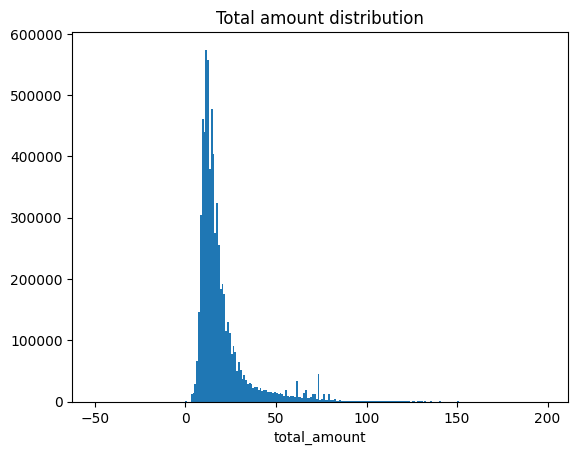

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.hist(full_df['total_amount'], 
         bins=np.arange(-50, 200))
plt.xlabel('total_amount')
plt.title('Total amount distribution')

There are alarmingly large total_amounts that definetely are outliers and should be removed from the data. Also there are negative amounts that should be dropped.

In [14]:
# Clipping unnecassary records
full_df = full_df[(full_df["total_amount"] > 0)&(full_df["total_amount"] < 1000)]
full_df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,PUBorough,PUZone,PUservice_zone,DOBorough,DOZone,DOservice_zone
0,1,2019-12-01 00:26:58,2019-12-01 00:41:45,1.0,4.20,1.0,N,142,116,2,...,0.3,18.30,2.5,None,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone
1,2,2019-12-01 00:03:51,2019-12-01 00:14:46,5.0,3.56,1.0,N,142,116,2,...,0.3,16.30,2.5,None,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone
2,2,2019-12-01 00:38:18,2019-12-01 00:54:47,1.0,4.48,1.0,N,142,116,1,...,0.3,23.16,2.5,None,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone
3,2,2019-12-01 01:23:23,2019-12-01 01:36:31,1.0,5.35,1.0,N,142,116,1,...,0.3,22.80,2.5,None,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone
4,2,2019-12-01 02:15:49,2019-12-01 02:32:47,1.0,4.02,1.0,N,142,116,2,...,0.3,17.80,2.5,None,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6896312,2,2019-12-14 15:14:00,2019-12-14 15:49:00,NaN,-9.01,NaN,None,61,2,0,...,0.3,49.20,NaN,None,Brooklyn,Crown Heights North,Boro Zone,Queens,Jamaica Bay,Boro Zone
6896313,1,2019-12-18 20:50:12,2019-12-18 21:48:38,1.0,0.00,1.0,N,250,2,1,...,0.3,60.70,0.0,None,Bronx,Westchester Village/Unionport,Boro Zone,Queens,Jamaica Bay,Boro Zone
6896314,2,2019-12-13 20:53:26,2019-12-13 21:22:14,NaN,10.89,NaN,None,197,2,0,...,0.3,42.83,NaN,None,Queens,Richmond Hill,Boro Zone,Queens,Jamaica Bay,Boro Zone
6896315,2,2019-12-11 23:28:07,2019-12-11 23:45:31,1.0,13.36,5.0,N,196,2,1,...,0.3,72.36,0.0,None,Queens,Rego Park,Boro Zone,Queens,Jamaica Bay,Boro Zone


Dealing with missing values

In [17]:
for col in full_df:
    print(col, 100*full_df[col].isnull().sum()/full_df.shape[0])

VendorID 0.0
tpep_pickup_datetime 0.0
tpep_dropoff_datetime 0.0
passenger_count 0.7420029876229542
trip_distance 0.0
RatecodeID 0.7420029876229542
store_and_fwd_flag 0.7420029876229542
PULocationID 0.0
DOLocationID 0.0
payment_type 0.0
fare_amount 0.0
extra 0.0
mta_tax 0.0
tip_amount 0.0
tolls_amount 0.0
improvement_surcharge 0.0
total_amount 0.0
congestion_surcharge 0.7420029876229542
airport_fee 100.0
PUBorough 0.0
PUZone 0.05455583404086188
PUservice_zone 0.8025090446298728
DOBorough 0.0
DOZone 0.266654368569322
DOservice_zone 0.9225464277421799


Amount of records with nulls values is negligible, we can theoretically drop them with no downside, but most popular gradient boosted decision tree frameworks work well with missing data
For more info: 
- https://xgboost.readthedocs.io/en/stable/faq.html#how-to-deal-with-missing-values
- https://catboost.ai/en/docs/concepts/algorithm-missing-values-processing
- https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#missing-value-handle

### Preprocessing

In [2]:
df.head(30)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-12-01 00:26:58,2019-12-01 00:41:45,1.0,4.20,1.0,N,142,116,2,14.5,3.0,0.5,0.00,0.00,0.3,18.30,2.5,None
1,1,2019-12-01 00:12:08,2019-12-01 00:12:14,1.0,0.00,1.0,N,145,145,2,2.5,0.5,0.5,0.00,0.00,0.3,3.80,0.0,None
2,1,2019-12-01 00:25:53,2019-12-01 00:26:04,1.0,0.00,1.0,N,145,145,2,2.5,0.5,0.5,0.00,0.00,0.3,3.80,0.0,None
3,1,2019-12-01 00:12:03,2019-12-01 00:33:19,2.0,9.40,1.0,N,138,25,1,28.5,0.5,0.5,10.00,0.00,0.3,39.80,0.0,None
4,1,2019-12-01 00:05:27,2019-12-01 00:16:32,2.0,1.60,1.0,N,161,237,2,9.0,3.0,0.5,0.00,0.00,0.3,12.80,2.5,None
5,1,2019-12-01 00:58:51,2019-12-01 01:08:37,2.0,1.00,1.0,N,161,230,2,6.5,3.0,0.5,0.00,0.00,0.3,10.30,2.5,None
6,1,2019-12-01 00:14:19,2019-12-01 00:27:06,0.0,1.70,1.0,Y,164,163,2,10.0,3.0,0.5,0.00,0.00,0.3,13.80,2.5,None
7,1,2019-12-01 00:29:35,2019-12-01 00:32:29,0.0,0.50,1.0,N,79,224,1,4.0,3.0,0.5,1.55,0.00,0.3,9.35,2.5,None
8,1,2019-12-01 00:42:19,2019-12-01 00:50:34,0.0,1.40,1.0,N,79,107,2,7.5,3.0,0.5,0.00,0.00,0.3,11.30,2.5,None
9,1,2019-12-01 00:19:48,2019-12-01 00:24:18,1.0,0.90,1.0,N,148,4,1,5.5,3.0,0.5,1.85,0.00,0.3,11.15,2.5,None


### Building trip distance estimator 

### Building trip duration estimator 

### Building trip price estimator 